# Quickstart: Planet Hosted Data API

Welcome to using Planet's Hosted Data API!
To learn more about this API, please reference our [Hosted Data documentation on the Planet Developer's Center](https://static.prod.planet-labs.com/devcenter/rel-hd-eap/apis/hosted-data/)

In this notebook, you will learn how to:

- Connect to the Hosted Data API using your Planet API Key
- Use the Hosted Data API to Create & Delete Folders
- Order Images to a Hosted Data Folder using the Orders API
- Explore Hosted Data Feature Collections
- Stream Cloud-Optimized Geotiffs (COGs) from Hosted Data Folders

**Please note that as the Hosted Data is available through the Planet Early Access Program, this notebook is a work-in-progress and will be updated as new functionality is added.**

**For questions/comments about this notebook, please contact us at developers@planet.com**

### Notebook Setup: Import Packages and Authenticate

In [1]:
import json
from matplotlib import pyplot
import os
from osgeo import gdal
import pathlib
import time

import requests
import planet
from planet import Session, DataClient, OrdersClient
import rasterio
from rasterio.windows import Window

In [2]:
# if your Planet API Key is not set as an environment variable, you can paste it below
if os.environ.get('PL_API_KEY', ''):
    API_KEY = os.environ.get('PL_API_KEY', '')
else:
    API_KEY = 'PASTE_YOUR_API_KEY_HERE'
    
# Setup the session
session = requests.Session()

# Authenticate
session.auth = (API_KEY, "")

#### Testing Hosted Data API Connection

Let's start by testing our API connection to ensure that everything is working properly.

In [3]:
hd_folders_url = 'https://api.planet.com/hosted-data/v1/folders'

In [4]:
# Here, we want to see a 200 Response.
response = requests.get(hd_folders_url, auth=session.auth)
response

<Response [200]>

We can also look at our response to see any existing Hosted Data API folders you may have access to.

In [5]:
response.json()

{'folders': [{'id': '3gIdabfXpEGyJKB710Jh',
   'name': 'Cleveland waterfront',
   'description': '',
   'created': '2021-07-21T14:59:35.467Z',
   'updated': '2022-09-20T19:39:44.597Z',
   'active_count': 5,
   '_owner': False,
   '_permissions': [{'allow': True, 'action': 'can-read'}],
   '_links': {'self': 'https://api.planet.com/hosted-data/v1/folders/3gIdabfXpEGyJKB710Jh',
    'contents': 'https://api.planet.com/hosted-data/v1/folders/3gIdabfXpEGyJKB710Jh/contents'}},
  {'id': 'afMB5gjjxsmXnCG2of5I',
   'name': 'Port of Long Beach Monitoring',
   'description': '',
   'created': '2021-03-17T21:28:44.364Z',
   'updated': '2021-03-17T22:52:34.28Z',
   'active_count': 4,
   '_owner': False,
   '_permissions': [{'allow': True, 'action': 'can-read'}],
   '_links': {'self': 'https://api.planet.com/hosted-data/v1/folders/afMB5gjjxsmXnCG2of5I',
    'contents': 'https://api.planet.com/hosted-data/v1/folders/afMB5gjjxsmXnCG2of5I/contents'}},
  {'id': 'g7GoGYrJEbSWgL3nLcKM',
   'name': 'Magesh

### Use the Hosted Data API to Create & Delete Folders

#### Create a Hosted Data Folder

In [6]:
# set content type to json
headers = {'content-type': 'application/json'}

In [7]:
# include the name of the folder you would like to create in the request
request = {"name":"test_folder"}

In [8]:
response = requests.post(hd_folders_url, data=json.dumps(request), auth=session.auth, headers=headers)
response

<Response [201]>

A 201 Response means that our folder has been created!

We can see our new folder `test_folder` by looking at the json response:

In [9]:
response.json()

{'id': 'Df5Gcn3pDvmKOg4V6o0E',
 'name': 'test_folder',
 'description': '',
 'created': '2023-01-31T21:45:24.636801Z',
 'updated': '2023-01-31T21:45:24.636801Z',
 'active_count': 0,
 '_owner': True,
 '_permissions': [{'allow': True, 'action': 'can-read'},
  {'allow': True, 'action': 'can-write'}],
 '_links': {'self': 'https://api.planet.com/hosted-data/v1/folders/Df5Gcn3pDvmKOg4V6o0E',
  'contents': 'https://api.planet.com/hosted-data/v1/folders/Df5Gcn3pDvmKOg4V6o0E/contents'}}

#### Delete a Hosted Data Folder

In [10]:
# Get the folder URL using the ID of the folder we just created
folder_url = hd_folders_url + '/' + response.json()['id']

In [11]:
# Send a delete request to the API
response = requests.delete(folder_url, auth=session.auth)
response

<Response [204]>

A 204 Response means that our request has succeeded, and there's no more info that needs to be returned to the response body.

We can confirm this by listing out our folders again. Notice that our `test_folder` is gone!

In [12]:
response = requests.get(hd_folders_url, auth=session.auth)
response.json()

{'folders': [{'id': '3gIdabfXpEGyJKB710Jh',
   'name': 'Cleveland waterfront',
   'description': '',
   'created': '2021-07-21T14:59:35.467Z',
   'updated': '2022-09-20T19:39:44.597Z',
   'active_count': 5,
   '_owner': False,
   '_permissions': [{'allow': True, 'action': 'can-read'}],
   '_links': {'self': 'https://api.planet.com/hosted-data/v1/folders/3gIdabfXpEGyJKB710Jh',
    'contents': 'https://api.planet.com/hosted-data/v1/folders/3gIdabfXpEGyJKB710Jh/contents'}},
  {'id': 'afMB5gjjxsmXnCG2of5I',
   'name': 'Port of Long Beach Monitoring',
   'description': '',
   'created': '2021-03-17T21:28:44.364Z',
   'updated': '2021-03-17T22:52:34.28Z',
   'active_count': 4,
   '_owner': False,
   '_permissions': [{'allow': True, 'action': 'can-read'}],
   '_links': {'self': 'https://api.planet.com/hosted-data/v1/folders/afMB5gjjxsmXnCG2of5I',
    'contents': 'https://api.planet.com/hosted-data/v1/folders/afMB5gjjxsmXnCG2of5I/contents'}},
  {'id': 'g7GoGYrJEbSWgL3nLcKM',
   'name': 'Magesh

### Order Images to a Hosted Data Folder Using the Orders API

Let's start by creating a folder once more since we deleted our original folder above.

In [13]:
# Create our `test_folder` once again
response = requests.post(hd_folders_url, data=json.dumps(request), auth=session.auth, headers=headers)
response.json()

{'id': 'NbPXf4W34M2B9TfEgnUO',
 'name': 'test_folder',
 'description': '',
 'created': '2023-01-31T21:45:28.426574Z',
 'updated': '2023-01-31T21:45:28.426574Z',
 'active_count': 0,
 '_owner': True,
 '_permissions': [{'allow': True, 'action': 'can-read'},
  {'allow': True, 'action': 'can-write'}],
 '_links': {'self': 'https://api.planet.com/hosted-data/v1/folders/NbPXf4W34M2B9TfEgnUO',
  'contents': 'https://api.planet.com/hosted-data/v1/folders/NbPXf4W34M2B9TfEgnUO/contents'}}

In [14]:
folder_id = response.json()['id']

Now, we can order images to this folder using the Orders API. There are a few steps involved:
1) Identify data to be ordered  
2) Build the order request  
3) Create and deliver the order to our hosted data folder

#### Identify Data To Be Ordered

In [15]:
# The area of interest (AOI) defined as a polygon
iowa_aoi = {
    "type":
    "Polygon",
    "coordinates": [[[-91.198465, 42.893071], [-91.121931, 42.893071],
                     [-91.121931, 42.946205], [-91.198465, 42.946205],
                     [-91.198465, 42.893071]]]
}

# The item IDs we wish to order
iowa_images = ['20200925_161029_69_2223', '20200925_161027_48_2223']

#### Build the Order Request

We don't yet have SDK suport for Hosted Data order requests so we'll need to build this json manually for now.

In this example, we are looking at some `item_ids` that correspond to `PSScene` images for a location in Iowa. For more information and examples on how to identify the item IDs corresponding to your needs, please see the [Data API documentation on our Developer Center](https://developers.planet.com/docs/apis/data/) and our Data API [jupyter notebooks](https://github.com/planetlabs/notebooks/blob/master/jupyter-notebooks/data-api-tutorials).

In [16]:
# Note that we're using the `folder_id` we just created.

iowa_order ={
'name': 'iowa_order',
 'products': [{'item_ids': ['20200925_161029_69_2223', '20200925_161027_48_2223'],
               'item_type': 'PSScene',
               'product_bundle': 'analytic_sr_udm2'}],
    'delivery': {
        'planet_folders': {
            'folder_id': folder_id}}}

In [17]:
# view our order request
iowa_order

{'name': 'iowa_order',
 'products': [{'item_ids': ['20200925_161029_69_2223',
    '20200925_161027_48_2223'],
   'item_type': 'PSScene',
   'product_bundle': 'analytic_sr_udm2'}],
 'delivery': {'planet_folders': {'folder_id': 'NbPXf4W34M2B9TfEgnUO'}}}

#### Create and Deliver the Order

First, we will create a function that will allow us to to create the order and wait until it is completed. Then, we will run this function using the Planet Orders Client.

In [18]:
async def create_and_deliver_order(order_request, client):
    '''Create and deliver an order.

    Parameters:
        order_request: An order request
        client: An Order client object
    '''
    with planet.reporting.StateBar(state='creating') as reporter:
        # Place an order to the Orders API
        order = await client.create_order(order_request)
        reporter.update(state='created', order_id=order['id'])
        # Wait while the order is being completed
        await client.wait(order['id'],
                          callback=reporter.update_state,
                          max_attempts=0)

    # Grab the details of the orders
    order_details = await client.get_order(order_id=order['id'])

    return order_details

In [19]:
async with planet.Session() as ps:
    # The Orders API client
    client = planet.OrdersClient(ps)
    # Create the order and deliver it to our Hosted Data Folder
    order_details = await create_and_deliver_order(iowa_order, client)

04:01 - order 73fd0127-6ffb-4be1-b62b-f36354e25749 - state: success


In [20]:
# Let's look at the details of the order that we just placed.
order_details

{'_links': {'_self': 'https://api.planet.com/compute/ops/orders/v2/73fd0127-6ffb-4be1-b62b-f36354e25749',
  'results': [{'delivery': 'success',
    'expires_at': '0001-01-01T00:00:00.000Z',
    'name': 'org-1/user:345186/folder-NbPXf4W34M2B9TfEgnUO/73fd0127-6ffb-4be1-b62b-f36354e25749/PSScene/20200925_161029_69_2223_3B_udm2.tif'},
   {'delivery': 'success',
    'expires_at': '0001-01-01T00:00:00.000Z',
    'name': 'org-1/user:345186/folder-NbPXf4W34M2B9TfEgnUO/73fd0127-6ffb-4be1-b62b-f36354e25749/PSScene/20200925_161029_69_2223_3B_AnalyticMS_metadata.xml'},
   {'delivery': 'success',
    'expires_at': '0001-01-01T00:00:00.000Z',
    'name': 'org-1/user:345186/folder-NbPXf4W34M2B9TfEgnUO/73fd0127-6ffb-4be1-b62b-f36354e25749/PSScene/20200925_161029_69_2223_3B_AnalyticMS_SR.tif'},
   {'delivery': 'success',
    'expires_at': '0001-01-01T00:00:00.000Z',
    'name': 'org-1/user:345186/folder-NbPXf4W34M2B9TfEgnUO/73fd0127-6ffb-4be1-b62b-f36354e25749/PSScene/20200925_161029_69_2223_metadata.j

Note that now, when we look at at the first item in our Hosted Data URL response, we see that our test folder has been populated, and the `updated` field reflects when the new items were added.

In [21]:
response = requests.get(hd_folders_url, auth=session.auth)
response.json()['folders'][0]

{'id': 'NbPXf4W34M2B9TfEgnUO',
 'name': 'test_folder',
 'description': '',
 'created': '2023-01-31T21:45:28.426574Z',
 'updated': '2023-01-31T21:48:29.736154Z',
 'active_count': 2,
 '_owner': True,
 '_permissions': [{'allow': True, 'action': 'can-read'},
  {'allow': True, 'action': 'can-write'}],
 '_links': {'self': 'https://api.planet.com/hosted-data/v1/folders/NbPXf4W34M2B9TfEgnUO',
  'contents': 'https://api.planet.com/hosted-data/v1/folders/NbPXf4W34M2B9TfEgnUO/contents'}}

### Listing Images in Hosted Data Folders as STAC

STAC, or SpatioTemporal Asset Catalog, is a framework for describing and cataloging spatiotemporal assets. We can list our hosted data images using the STAC framework.

In [22]:
# Get the folder URL using the ID of the folder we just created
folder_id = response.json()['folders'][0]['id']

# This is the API endpoint for 
folders = 'https://api.planet.com/hosted-data/v1/stac/root-catalog/folders/'

folder_url = folders + folder_id

In [23]:
# Here, we can see the items in our folder listed as STAC

response = requests.get(folder_url, auth=session.auth)
response.json()

{'id': 'planet_folder_NbPXf4W34M2B9TfEgnUO',
 'type': 'Catalog',
 'title': 'test_folder',
 'stac_version': '1.0.0',
 'description': 'test_folder',
 'links': [{'rel': 'root',
   'href': 'https://api.planet.com/hosted-data/v1/stac/root-catalog',
   'type': 'application/json'},
  {'rel': 'parent',
   'href': 'https://api.planet.com/hosted-data/v1/stac/root-catalog/folders',
   'type': 'application/json'},
  {'rel': 'item',
   'href': 'https://api.planet.com/hosted-data/v1/stac/root-catalog/folders/NbPXf4W34M2B9TfEgnUO/WqJmmP6TM6CPamfpJ6Udet',
   'type': 'application/json',
   'title': 'PSScene:20200925_161029_69_2223 - WqJmmP6TM6CPamfpJ6Udet'},
  {'rel': 'item',
   'href': 'https://api.planet.com/hosted-data/v1/stac/root-catalog/folders/NbPXf4W34M2B9TfEgnUO/RwkBPv98h9iUgedLseGWhj',
   'type': 'application/json',
   'title': 'PSScene:20200925_161027_48_2223 - RwkBPv98h9iUgedLseGWhj'},
  {'rel': 'self',
   'href': 'https://api.planet.com/hosted-data/v1/stac/root-catalog/folders/NbPXf4W34M2B

Note that we have 2 items listed in thef folder above, labeled as `item`!

### Exploring Hosted Data Feature Collections

Now that we have data in a hosted data folder, we can look at our collections.

Each collection shows similar folder contents in a feature collection format using the STAC framework.

For example, a folder could contain both `PSScene` and `SkySatCollect` items and their respective assets. Using the STAC framework, each of these different types of images are separated into their own feature collections - one for `PSScene`, another for `SkySatCollect` - which then show the items (and their respective assets) that correspond.

This framework is represented in the graphic below:

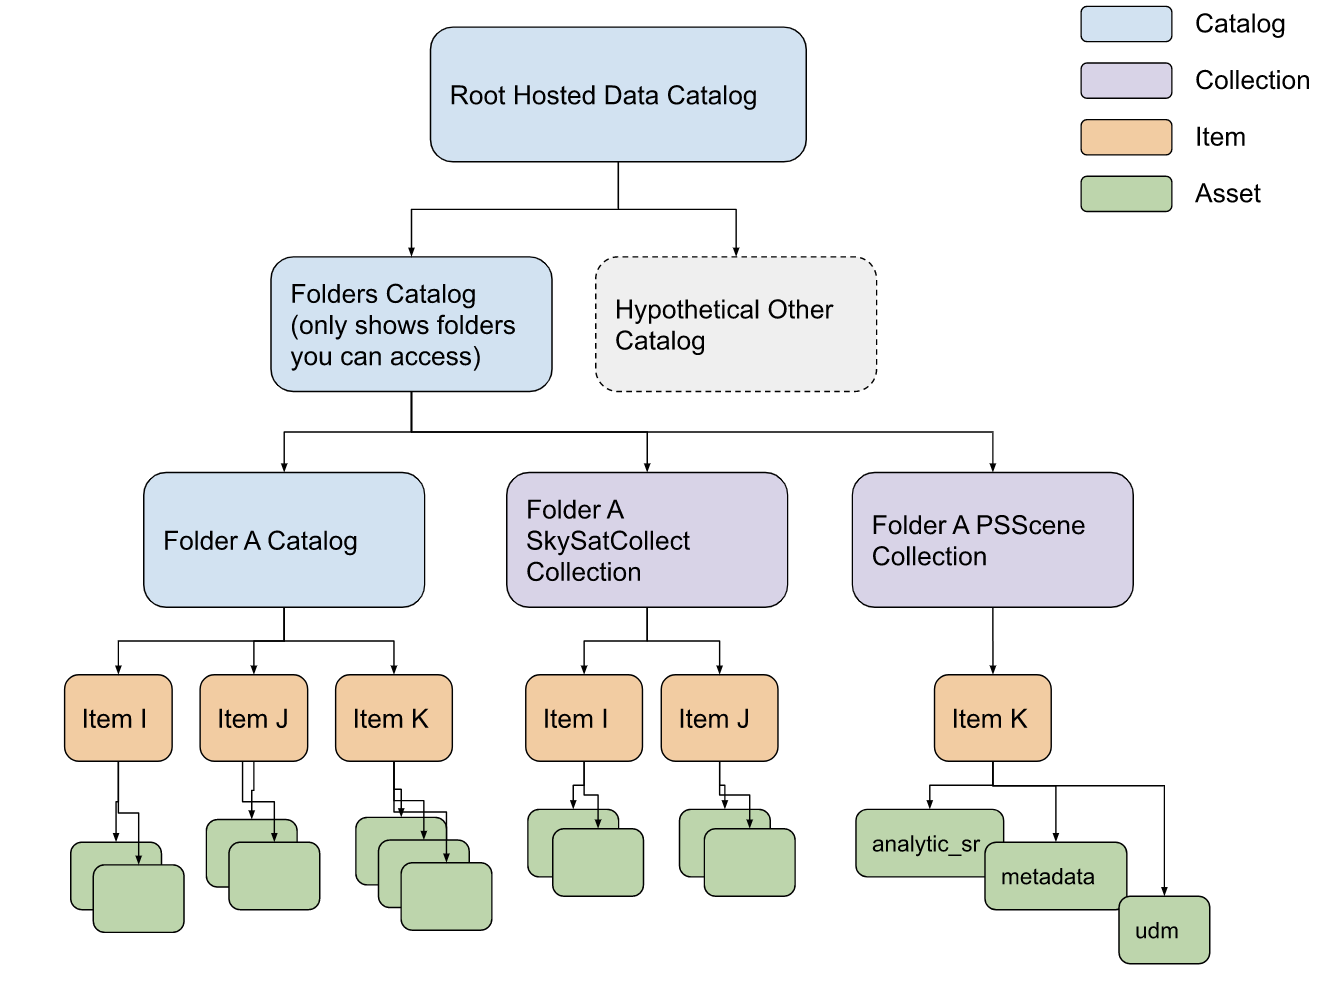

Let's take a look at our collections:

In [24]:
hd_collections_url = 'https://api.planet.com/hosted-data/v1/stac/root-catalog/folders/collections'

In [77]:
collections_response = requests.get(hd_collections_url, auth=session.auth)
response

<Response [200]>

In [78]:
collections_response.json()

{'collections': [{'type': 'Collection',
   'id': 'NbPXf4W34M2B9TfEgnUO_PSScene',
   'title': 'test_folder - PSScene',
   'description': 'test_folder - PSScene',
   'extent': {'spatial': {'bbox': [[-180, -90], [180, 90]]},
    'temporal': {'interval': [[None, None]]}},
   'license': 'proprietary',
   'stac_version': '1.0.0',
   'links': [{'rel': 'root',
     'href': 'https://api.planet.com/hosted-data/v1/stac/root-catalog',
     'type': 'application/json'},
    {'rel': 'parent',
     'href': 'https://api.planet.com/hosted-data/v1/stac/root-catalog/folders/collections',
     'type': 'application/json'},
    {'rel': 'self',
     'href': 'https://api.planet.com/hosted-data/v1/stac/root-catalog/folders/collections/NbPXf4W34M2B9TfEgnUO_PSScene',
     'type': 'application/json'},
    {'rel': 'items',
     'href': 'https://api.planet.com/hosted-data/v1/stac/root-catalog/folders/collections/NbPXf4W34M2B9TfEgnUO_PSScene/items',
     'type': 'application/json',
     'title': 'Items in collection 

Above, we see a list of all of our collections within each of our folders.

Let's take a look at the first one of these collections below, corresponding to `PSOrthoTile` images:

In [79]:
collections_response.json()['collections'][0]

{'type': 'Collection',
 'id': 'NbPXf4W34M2B9TfEgnUO_PSScene',
 'title': 'test_folder - PSScene',
 'description': 'test_folder - PSScene',
 'extent': {'spatial': {'bbox': [[-180, -90], [180, 90]]},
  'temporal': {'interval': [[None, None]]}},
 'license': 'proprietary',
 'stac_version': '1.0.0',
 'links': [{'rel': 'root',
   'href': 'https://api.planet.com/hosted-data/v1/stac/root-catalog',
   'type': 'application/json'},
  {'rel': 'parent',
   'href': 'https://api.planet.com/hosted-data/v1/stac/root-catalog/folders/collections',
   'type': 'application/json'},
  {'rel': 'self',
   'href': 'https://api.planet.com/hosted-data/v1/stac/root-catalog/folders/collections/NbPXf4W34M2B9TfEgnUO_PSScene',
   'type': 'application/json'},
  {'rel': 'items',
   'href': 'https://api.planet.com/hosted-data/v1/stac/root-catalog/folders/collections/NbPXf4W34M2B9TfEgnUO_PSScene/items',
   'type': 'application/json',
   'title': 'Items in collection NbPXf4W34M2B9TfEgnUO_PSScene'}]}

Here, we can see some metadata about this feature collection. We see that this collection corresponds to `PSScene` images for our folder `test_folder`.

Let's look at the items in this feature collection:

In [80]:
collection_items = collections_response.json()['collections'][0]['links'][3]['href']
collection_items

'https://api.planet.com/hosted-data/v1/stac/root-catalog/folders/collections/NbPXf4W34M2B9TfEgnUO_PSScene/items'

In [81]:
response = requests.get(collection_items, auth=session.auth)
response

<Response [200]>

In [83]:
response.json()

{'type': 'FeatureCollection',
 'features': [{'id': 'WqJmmP6TM6CPamfpJ6Udet',
   'type': 'Feature',
   'title': 'PSScene:20200925_161029_69_2223 - WqJmmP6TM6CPamfpJ6Udet',
   'stac_version': '1.0.0',
   'stac_extensions': ['https://stac-extensions.github.io/web-map-links/v1.0.0/schema.json'],
   'properties': {'acquired': '2020-09-25T16:10:29.698707Z',
    'anomalous_pixels': 0,
    'asset_type': 'ortho_analytic_4b_sr',
    'clear_confidence_percent': 99,
    'clear_percent': 100,
    'cloud_cover': 0,
    'cloud_percent': 0,
    'datetime': '2020-09-25T16:10:29.698707Z',
    'ground_control': True,
    'gsd': 3.8,
    'heavy_haze_percent': 0,
    'instrument': 'PSB.SD',
    'item_id': '20200925_161029_69_2223',
    'item_type': 'PSScene',
    'light_haze_percent': 0,
    'order_id': '73fd0127-6ffb-4be1-b62b-f36354e25749',
    'pixel_resolution': 3,
    'provider': 'planetscope',
    'published': '2020-09-26T05:22:15Z',
    'publishing_stage': 'finalized',
    'quality_category': 'stand

Notice that the above is a `Feature Collection`. We can see the items in this feature collection represented visually if we paste the above response into [geojson.io](https://geojson.io/#map=2/0/20):

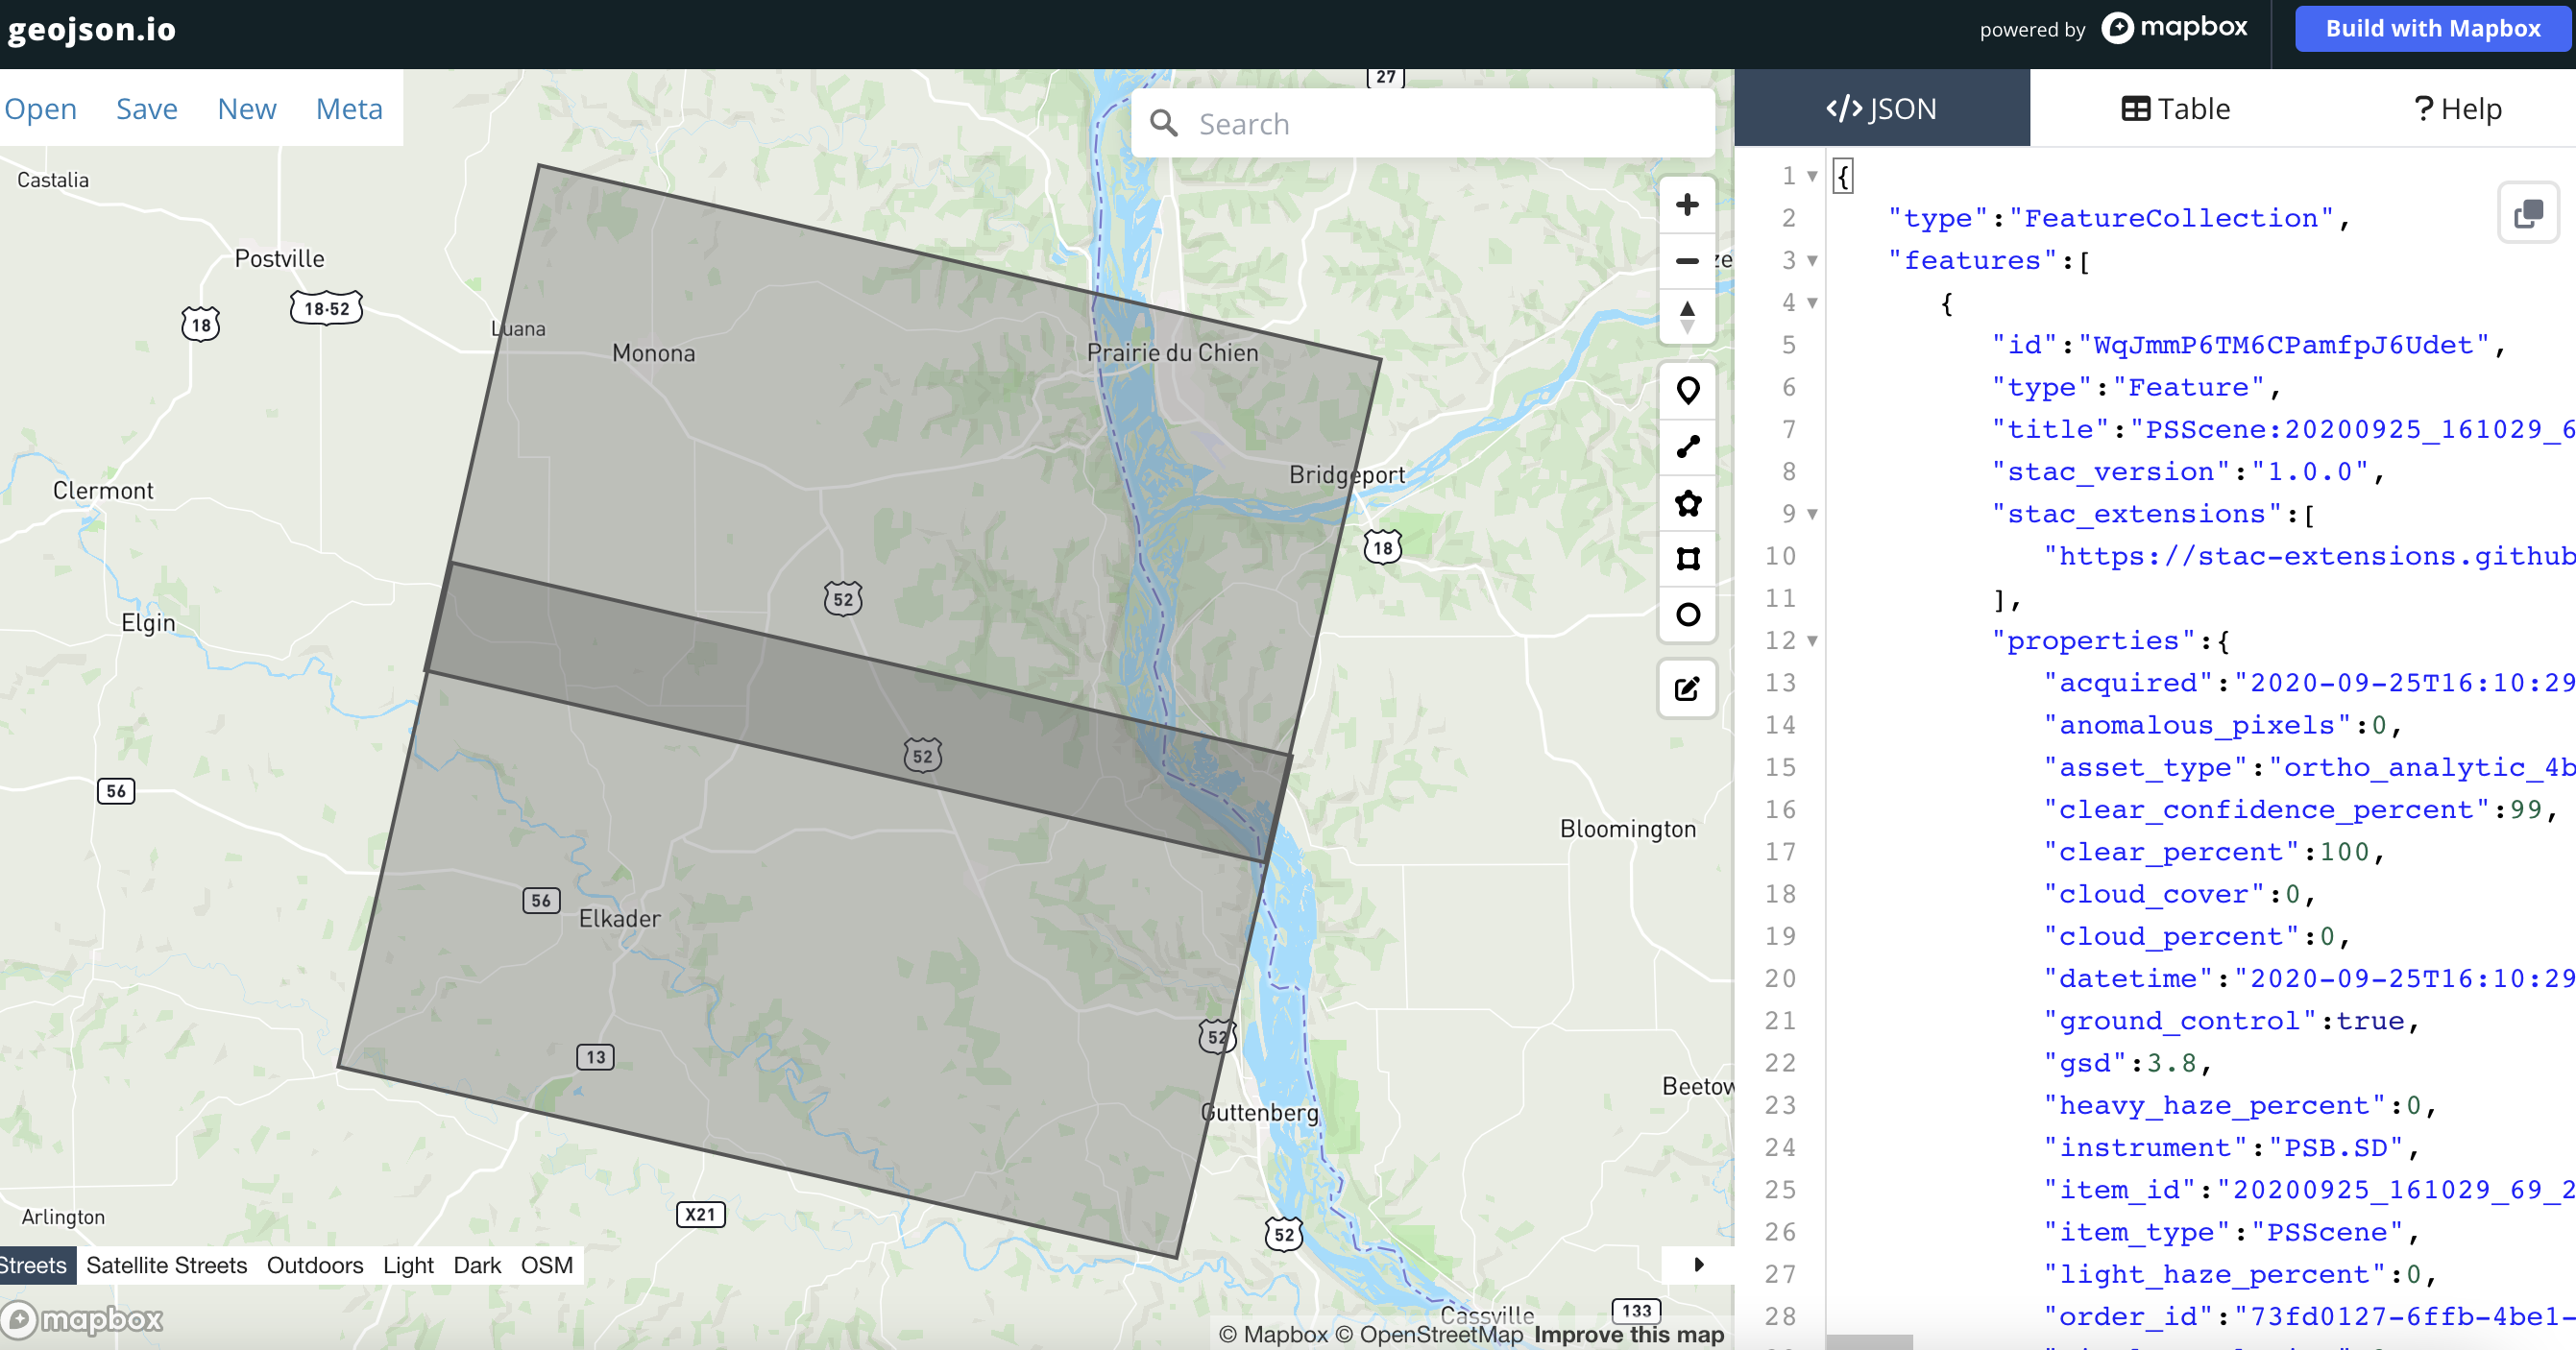

Here we can see both of our PSScene images and where they overlap!

### Stream a Hosted Data COG

A [COG](https://www.cogeo.org/) (cloud-optimized geotiff) is a type of GeoTiff file that has been formatted to work in the cloud. Because of this, it is also possible to work with COGs from the clpud directly, instead of downloading images to your local machine.

Let's start by taking a look at our first of the two `item`s in our Feature Collection:

In [84]:
item_link = response.json()['links'][2]['href']

In [85]:
response = requests.get(item_link, auth=session.auth)

By looking at the response below, we can see detailed information about our image including its properties, coordinates, and assets.

In [86]:
response.json()

{'type': 'FeatureCollection',
 'features': [{'id': 'WqJmmP6TM6CPamfpJ6Udet',
   'type': 'Feature',
   'title': 'PSScene:20200925_161029_69_2223 - WqJmmP6TM6CPamfpJ6Udet',
   'stac_version': '1.0.0',
   'stac_extensions': ['https://stac-extensions.github.io/web-map-links/v1.0.0/schema.json'],
   'properties': {'acquired': '2020-09-25T16:10:29.698707Z',
    'anomalous_pixels': 0,
    'asset_type': 'ortho_analytic_4b_sr',
    'clear_confidence_percent': 99,
    'clear_percent': 100,
    'cloud_cover': 0,
    'cloud_percent': 0,
    'datetime': '2020-09-25T16:10:29.698707Z',
    'ground_control': True,
    'gsd': 3.8,
    'heavy_haze_percent': 0,
    'instrument': 'PSB.SD',
    'item_id': '20200925_161029_69_2223',
    'item_type': 'PSScene',
    'light_haze_percent': 0,
    'order_id': '73fd0127-6ffb-4be1-b62b-f36354e25749',
    'pixel_resolution': 3,
    'provider': 'planetscope',
    'published': '2020-09-26T05:22:15Z',
    'publishing_stage': 'finalized',
    'quality_category': 'stand

#### Get the Webcog Asset Link

Let's take a look at the `webcog` asset and grab the link:

In [ ]:
# UPDATE THIS CELL

In [ ]:
cog_link = response.json()['assets']['webcog']['href']

If we wanted to just download the image to our local machine, we could do:

In [ ]:
!gdal_translate $cog_link -co COMPRESS=LZW

However, with COGs, we can also do a windowed read, which allows us to stream a portion of the image to our notebook without having to download the whole thing! 

Let's do that here using rasterio.

For more information on windowed reads using rasterio, check out the rasterio documentation [here.](https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html)

#### Define the Image Window

In [ ]:
# We can define the size of the image that we would like. Here, we're looking at a 768 by 768 pixel square
with rasterio.open(cog_link) as src:
    w = src.read(1, window=Window(0, 0, 768, 768))

In [ ]:
print(w.shape)

In [ ]:
pyplot.imshow(w, cmap='Purples')
pyplot.show()